In [4]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

2023-04-07 14:46:49.941682: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


ModuleNotFoundError: No module named 'object_detection'

In [21]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [ ]:
def plot_detections(image_np, boxes, classes, scores, category_index, figsize=(12, 16), image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

In [ ]:
def plot_detections_tensor(image_np, boxes, classes, scores, category_index, figsize=(12, 16),image_name=None):
  
  """Draws bounding boxes, masks, and keypoints on batch of image tensors.
  Args:
    images: A 4D uint8 image tensor of shape [N, H, W, C]. If C > 3, additional
      channels will be ignored. If C = 1, then we convert the images to RGB
      images.
    boxes: [N, max_detections, 4] float32 tensor of detection boxes.
    classes: [N, max_detections] int tensor of detection classes. Note that
      classes are 1-indexed.
    scores: [N, max_detections] float32 tensor of detection scores.
    category_index: a dict that maps integer ids to category dicts. e.g.
      {1: {1: 'dog'}, 2: {2: 'cat'}, ...}
    
    Returns:
    4D image tensor of type uint8, with boxes drawn on top.
    """
  image_np_with_annotations = image_np.copy()
  img_tensor = viz_utils.draw_bounding_boxes_on_image_tensors(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.7)
  
  arr_ = np.squeeze(img_tensor) # you can give axis attribute if you wanna squeeze in specific dimension
  plt.imshow(arr_)
  plt.show()

In [16]:
#generate numpy of images and visualize data
def viz_data(path_file_name):
    """ a list of file path names are provided """
    train_images_np = []
    for image_item in path_file_name:
        train_images_np.append(load_image_into_numpy_array(image_item))
        
        plt.rcParams['axes.grid'] = False
        plt.rcParams['xtick.labelsize'] = False
        plt.rcParams['ytick.labelsize'] = False
        plt.rcParams['xtick.top'] = False
        plt.rcParams['xtick.bottom'] = False
        plt.rcParams['ytick.left'] = False
        plt.rcParams['ytick.right'] = False
        plt.rcParams['figure.figsize'] = [14, 7]


        for idx, train_image_np in enumerate(train_images_np):
            plt.subplot(2, 3, idx+1)
            plt.imshow(train_image_np)
            plt.show()
    
    return train_images_np
        
    

['test.jpg']


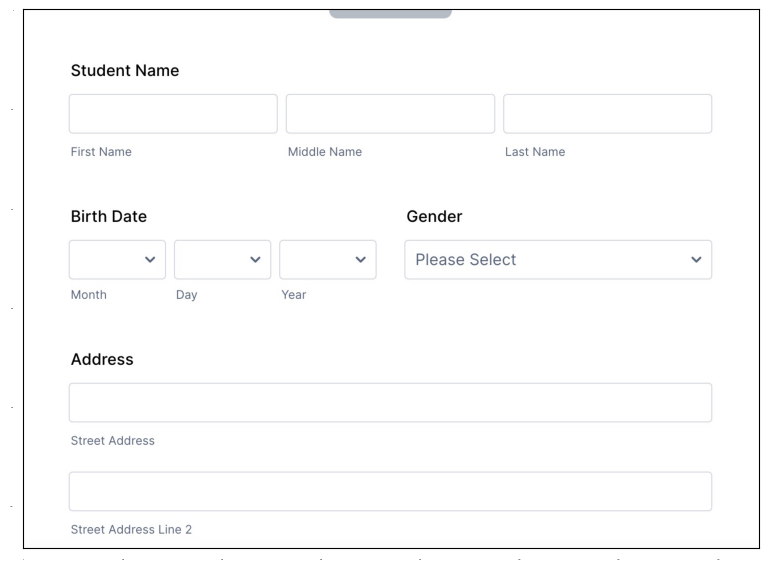

In [22]:
#image data file path
data_dir = "..//data"
#get all the jpeg file names 
file_names = []
os.chdir(data_dir)
for file in glob.glob("*.jpg"):
    file_names.append(file)
train_images_np = viz_data(file_names)


In [25]:
#fetch ground truth boxes and indices class list in .npy format 
#these 2 files are generated from another script called bbox

gt_boxes = np.load('../data/bbox.npy')
indices_class_list = np.load('../data/indices_class_list.npy')

In [23]:
#define category index
num_classes = 3
input_field_id = 1
dropdown_id = 2
text_id = 3

category_index = {
    input_field_id: {'id': input_field_id, 'name': 'Input Field'},
    dropdown_id:{'id':dropdown_id, 'name':'Drop Down'},
    text_id:{'id':text_id, 'name':'Text'}
    }

In [ ]:
# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index. This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np,indices_class) in zip(
    train_images_np, gt_boxes,indices_class_list):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = indices_class-1
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))

print('Done prepping data.')


In [ ]:
#for multiple object detection
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%
print(type(train_images_np[0]))
plt.figure(figsize=(30, 15))
for idx in range(1):
  plt.subplot(2, 3, idx+1)
  dummy_scores = tf.convert_to_tensor(np.ones((1, gt_boxes[idx].shape[0]),dtype=np.float32))

 

  tr_img_expdims = np.expand_dims(train_images_np[idx], axis=0)

  plot_detections_tensor(
      tf.convert_to_tensor(tr_img_expdims),
      tf.convert_to_tensor(np.expand_dims(gt_boxes[idx], axis=0)),
      indices_class_list, 
      dummy_scores, category_index)
plt.show()